<a href="https://colab.research.google.com/github/dariamarone/BookSystem/blob/master/BookSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A recommendation system that predict the rating or preference a user would give to an item *given his old item ratings* or preferences. 

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from keras.layers import Input, Embedding, Flatten, Dense, Concatenate , BatchNormalization
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Loading Data

In [12]:
dataset = pd.read_csv('./ratings.csv')
print('Dataset shape: ',dataset.shape)
n_users = len(dataset.user_id.unique())
print('Number of users:', n_users)
n_books = len(dataset.book_id.unique())
print("Number of books:", n_books)
dataset.head(3)

Dataset shape:  (981756, 3)
Number of users: 53424
Number of books: 10000


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5


Split data in training and test set

In [13]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)
train.head(3)

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4


In [14]:
test.head(3)

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3


# Creating neural network

In [37]:
#Book embedding path

#create a 1-dimensional tensor named Book-Input(firs layer fo the model)
book_input = Input(shape=[1], name="Book-Input")
#turns positive integers (indexes) into dense vectors of fixed size (output-dim =5)
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
#Flatt the input
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-hidden-layers
#applies a transformation that maintains the mean to 0 and the standard deviation to 1.
n1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=False, scale=False, moving_mean_initializer='zeros', moving_variance_initializer='ones')(conc)

fc1 = Dense(128, activation='elu')(n1)
fc2 = Dense(32, activation='elu')(fc1)
fc3 = Dense(32, activation='elu')(fc2)

#output layer
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, book_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
____________________________________________________________________________________________

In [55]:
# Train the model with an early stopping callback
es = EarlyStopping(monitor='val_loss', patience=2, mode='auto', baseline=None, restore_best_weights=True)
history = model.fit([train.user_id,train.book_id], 
                    train.rating, 
                    epochs=10,
                    verbose=1,
                    callbacks=[es],
                    batch_size=256,
                    validation_split=0.2,
                    shuffle=True)

Train on 628323 samples, validate on 157081 samples
Epoch 1/10
628323/628323 [==============================] - 21s 34us/step - loss: 0.4356 - val_loss: 0.7029
Epoch 2/10
628323/628323 [==============================] - 21s 33us/step - loss: 0.4230 - val_loss: 0.7187
Epoch 3/10
628323/628323 [==============================] - 20s 32us/step - loss: 0.4152 - val_loss: 0.7416


In [56]:
test_acc = model.evaluate([test.user_id, test.book_id], test.rating)
print('\n Test accuracy:', test_acc )

196352/196352 [==============================] - 6s 28us/step

 Test accuracy: 0.8611491099631382


In [0]:
#ratings prediction for the first 5 books in test set
predictions = model.predict([test.user_id.head(5), test.book_id.head(5)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,5)]

[4.8029113] 5
[3.7948833] 4
[3.4463873] 3
[4.1681104] 5
[3.5592906] 3


[None, None, None, None, None]

# Dimensional reduction and Visualization

In [0]:
#Estract embeddings (5 dimension)
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights[:5]

array([[ 0.00385399, -0.03217363, -0.01882761, -0.00694631, -0.01964712],
       [-0.04206993,  0.12316791,  0.14457965,  0.09486916,  0.00685943],
       [-0.09357303, -0.14463787, -0.04328566, -0.07361656, -0.08827742],
       [-0.01468324,  0.16871871, -0.17947476, -0.03626771,  0.0007408 ],
       [ 0.16904202,  0.23057488,  0.04091303, -0.21049148, -0.12417477]],
      dtype=float32)


     Scatterplot PCA-space



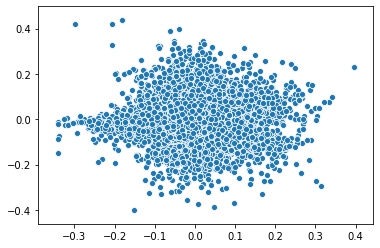

In [0]:
#PCA transformation embeddings (2 dimensions) 

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x = pca_result[:,0], y = pca_result[:,1])
print("\n     Scatterplot PCA-space\n")

Check on sum: 1.0000001


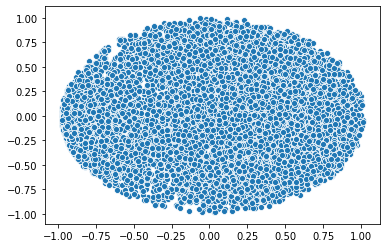

In [0]:
#vector normalization on the axis 1     

book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
#check 
print ('Check on sum:',np.sum(np.square(book_em_weights[0])))

#visualization on PCA space
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [0]:
##TSNE transformation embeddings (2 dimensions)
 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.022s...
[t-SNE] Computed neighbors for 10001 samples in 0.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.155844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.245537
[t-SNE] KL


     Scatterplot TSNE-space



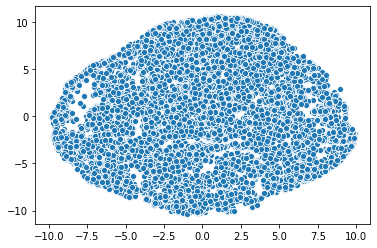

In [0]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])
print("\n     Scatterplot TSNE-space\n")

## Recommendation system

The system recommend to a user the best books looking for the best predicted ratings for that specific user. Are sown items similar to those appreciated by the user himself in the past.

In [0]:
#creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
print('array book_data: ', book_data[:5])
user = np.array([1 for i in range(len(book_data))])
print ('array user:', user[:5])

array book_data:  [1 2 3 4 5]
array user: [1 1 1 1 1]


In [0]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
print('Predicted book ids:', recommended_book_ids)
print('Predicted scores:', predictions[recommended_book_ids])


Predicted book ids: [8945 5206 6919 9565 5579]
Predicted scores: [4.8154206 4.8036523 4.711264  4.70421   4.7010026]


In [0]:
#first books in dataset
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [0]:
#first five books recommended
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
5205,5206,13066,13066,2257006,31,446695688,9.780447e+12,Carl Hiaasen,2000.0,Sick Puppy,Sick Puppy,eng,3.88,18248,19594,1069,193,861,5077,8434,5029,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
5578,5579,9436632,9436632,14321219,39,61935107,9.780062e+12,Sophie Jordan,2011.0,Vanish,"Vanish (Firelight, #2)",en-US,3.95,25947,27520,2028,476,1645,6345,9236,9818,https://images.gr-assets.com/books/1327879019m...,https://images.gr-assets.com/books/1327879019s...
6918,6919,55354,55354,893440,22,786887583,9.780787e+12,George Carlin,2001.0,Napalm & Silly Putty,Napalm & Silly Putty,eng,4.12,12798,13437,316,141,465,2561,4724,5546,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8944,8945,32529,32529,3214115,40,752848267,9.780753e+12,Lisa Gardner,2001.0,The Next Accident,"The Next Accident (Quincy & Rainie, #3)",en-US,4.16,11261,13328,513,49,231,2323,5612,5113,https://images.gr-assets.com/books/1348816896m...,https://images.gr-assets.com/books/1348816896s...
9564,9565,24819476,24819476,44460264,18,316261130,9.780316e+12,Elin Hilderbrand,2015.0,Winter Stroll,Winter Stroll (Winter #2),NaN,3.70,8397,9754,979,133,640,3133,3971,1877,https://images.gr-assets.com/books/1431957489m...,https://images.gr-assets.com/books/1431957489s...
